In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import numpy as np
import random
import sys
sys.path.append('../tools')

import os

import torch

import pandas as pd
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
import data_utility, annotation_utility
from models.rns_dataloader import *
from active_learning_utility import get_strategy
from active_learning_data import Data
from active_learning_net import Net
from copy import deepcopy
from models.SwaV import SwaV
from models.LSTMDownStream import SupervisedDownstream
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", ".*Set a lower value for log_every_n_steps if you want to see logs for the training epoch*")

In [3]:
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    # True ensures the algorithm selected by CUFA is deterministic
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)
    # False ensures CUDA select the same algorithm each time the application is run
    torch.backends.cudnn.benchmark = False

import pytorch_lightning
pytorch_lightning.utilities.seed.seed_everything(seed=random_seed, workers=True)

Global seed set to 42


42

In [4]:
data_dir = "../../../user_data/"
log_folder_root = '../../../user_data/logs/'
ckpt_folder_root = '../../../user_data/checkpoints/'

In [22]:
strategy_name = 'LeastConfidence'

In [6]:
nStart = 1
nEnd = 20
nQuery = 2

In [7]:
args_task = {'n_epoch': 40,
             'transform_train': True,
             'strategy_name': strategy_name,
             'transform': False,
             'loader_tr_args': {'batch_size': 2, 'num_workers': 4, 'collate_fn': collate_fn,
                                'drop_last': True,'persistent_workers':True},
             'loader_te_args': {'batch_size': 2, 'num_workers': 8, 'collate_fn': collate_fn,
                                'drop_last': True,'persistent_workers':True}
             }

In [8]:
# raw_annotations = pd.read_csv(data_dir + 'full_updated_anns_annotTbl_cleaned.csv')
# ids = list(np.unique(raw_annotations[raw_annotations['descriptions'].notnull()]['HUP_ID']))
# # ids = list(np.unique(raw_annotations['HUP_ID']))
#
# data_import = data_utility.read_files(path=data_dir+'rns_data', path_data=data_dir+'rns_raw_cache', patientIDs=ids,
#                                       verbose=True)  # Import data with annotation

In [9]:
# data_list = os.listdir(data_dir+'rns_test_cache')
# print(data_list)
data_list = ['HUP047.npy', 'HUP084.npy', 'HUP096.npy', 'HUP109.npy', 'HUP121.npy', 'HUP129.npy', 'HUP131.npy',
             'HUP137.npy', 'HUP147.npy', 'HUP156.npy', 'HUP159.npy', 'HUP182.npy', 'HUP197.npy', 'HUP199.npy',
             'RNS026.npy', 'RNS029.npy']
# data_list = os.listdir(data_dir+'rns_test_cache')[1:]

# data_list = ['HUP182.npy',   'HUP129.npy',   'HUP109.npy', 'HUP156.npy', 'HUP096.npy', 'RNS026.npy',  'HUP159.npy']
# data_list = ['RNS026.npy', 'HUP159.npy', 'HUP129.npy', 'HUP096.npy', 'HUP182.npy']
train_data, train_label, test_data, test_label, train_index, test_index = get_data_by_episode(data_list, split=0.8, patient_out=True)
# data, label,_,_ = get_data(data_list, split=1)
# train_data, test_data, train_label, test_label = sklearn.model_selection.train_test_split(data, label, test_size=0.8, random_state=42)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

16it [00:08,  1.97it/s]

(992,)
(992,)
(270,)
(270,)


In [10]:
X_train = np.concatenate(train_data)
y_train = np.concatenate(train_label)
X_test = np.concatenate(test_data)
y_test = np.concatenate(test_label)
index_train = np.concatenate(train_index)
index_test = np.concatenate(test_index)
seq_len_train = np.array([y.shape[0] for y in train_label])
seq_len_test = np.array([y.shape[0] for y in test_label])

In [11]:
seq_len_train

array([90, 90, 38, 90, 90, 90, 74, 90, 90, 90, 75, 60, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 57, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 30, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 73, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 89, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       89, 90, 90, 90, 90, 90, 58, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 72, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90

In [12]:
# def episode_to_window_translation(self, episode_index):
#

In [13]:
episode_index = 2
cum_sum = np.cumsum(seq_len_train)
if episode_index>0:
    start_index = cum_sum[episode_index-1]
    end_index = cum_sum[episode_index]
else:
    start_index = 0
    end_index = cum_sum[episode_index]

In [14]:
np.arange(start_index,end_index)

array([180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217])

In [15]:
cum_sum[episode_index-1]

180

In [16]:
X_train.shape

(85111, 249, 36)

In [17]:
n_pool = len(train_data)
n_test = len(test_data)

NUM_INIT_LB = int(nStart * n_pool / 100)
NUM_QUERY = int(nQuery * n_pool / 100) if nStart != 100 else 0
NUM_ROUND = int((int(nEnd * n_pool / 100) - NUM_INIT_LB) / NUM_QUERY) if nStart != 100 else 0
if NUM_QUERY != 0:
    if (int(nEnd * n_pool / 100) - NUM_INIT_LB) % NUM_QUERY != 0:
        NUM_ROUND += 1

print(NUM_INIT_LB)
print(NUM_QUERY)
print(NUM_ROUND)

9
19
10


In [18]:
dataset = Data(X_train, y_train, X_test, y_test, seq_len_train, seq_len_test, RNS_Active_by_episode_LSTM, args_task)

In [19]:
swav = SwaV().load_from_checkpoint(
    ckpt_folder_root + 'rns_swav_50_12/rns_swav-epoch=82-swav_loss=2.58204.ckpt')
model = SupervisedDownstream(swav.backbone)
# initialize model and save the model state
modelstate = deepcopy(model.state_dict())
device = "cuda" if torch.cuda.is_available() else "cpu"

net = Net(model, args_task, device, ckpt_folder_root = 'rns_active', log_folder_root = 'rns_active')

In [23]:
strategy = get_strategy(strategy_name, dataset, net, None, args_task, rns_data = True)

In [25]:
# initial round of training, round 0
dataset.initialize_labels(NUM_INIT_LB)

In [26]:
# next(iter(RNS_Active_by_episode_LSTM(dataset.combine_window_to_episode(dataset.X_train,dataset.labeled_idxs,dataset.seq_len_train),
#                            dataset.combine_window_to_episode(dataset.Y_train,dataset.labeled_idxs,dataset.seq_len_train),
#                            True)))

In [27]:
dummpy_index = np.arange(len(dataset.labeled_idxs))

In [28]:
strategy.train()

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 180. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 65. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 121. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 269. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
C:\Users\Patrick Xu\AppData\Local\P

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [21]:
# q_idxs = strategy.query(NUM_QUERY)

In [118]:
_, unlabeled_data = strategy.dataset.get_unlabeled_data()
probs, seq_len = strategy.predict_prob(unlabeled_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

In [115]:
np.cumsum(torch.tensor(seq_len).squeeze(1).numpy())

array([   90,   180,   218,   308,   398,   488,   562,   652,   742,
         832,   907,   967,  1057,  1147,  1237,  1327,  1417,  1507,
        1597,  1687,  1777,  1867,  1957,  2047,  2137,  2227,  2317,
        2407,  2497,  2587,  2677,  2767,  2857,  2947,  3037,  3127,
        3217,  3307,  3397,  3487,  3577,  3667,  3757,  3814,  3904,
        3994,  4084,  4174,  4264,  4354,  4444,  4534,  4624,  4714,
        4804,  4894,  4984,  5074,  5164,  5254,  5344,  5434,  5524,
        5614,  5704,  5794,  5884,  5974,  6064,  6154,  6244,  6334,
        6424,  6514,  6604,  6694,  6784,  6874,  6964,  7054,  7144,
        7234,  7324,  7414,  7504,  7594,  7624,  7714,  7804,  7894,
        7984,  8074,  8164,  8254,  8344,  8434,  8524,  8614,  8687,
        8777,  8867,  8957,  9047,  9137,  9227,  9317,  9407,  9497,
        9587,  9677,  9767,  9857,  9947, 10037, 10127, 10217, 10307,
       10397, 10487, 10577, 10667, 10757, 10847, 10937, 11027, 11116,
       11206, 11296,

In [116]:
len(probs)

84332

In [97]:
torch.mean(probs[:,0])

tensor(0.8593)

In [29]:
def max_subarray_sum_with_indices_soft_margin(arr, margin):
    if not arr:  # handle empty array case
        return 0, -1, -1

    max_ending_here = max_so_far = arr[0]
    start = end = 0
    temp_start = 0
    # Introduce a margin count to keep track of how many times we've applied the soft margin
    margin_count = 0

    for i, x in enumerate(arr[1:], start=1):
        if x > max_ending_here + x:
            max_ending_here = x
            temp_start = i
            margin_count = 0  # Reset margin count for a new start
        else:
            # Apply soft margin: if the addition is negative but within the margin, continue the current subarray
            if max_ending_here + x - max_ending_here < margin:
                margin_count += 1
                max_ending_here += x
            else:
                max_ending_here += x

        if max_ending_here > max_so_far:
            max_so_far = max_ending_here
            start = temp_start
            end = i
            margin_count = 0  # Reset margin count after finding a new max

    return max_so_far, start, end



# Example usage:
arr = [-2, -3, 4, -1, -2, 1, 5, -3]
# min_sum, start_index, end_index = min_subarray_sum_with_indices(arr)
max_sum, start_index, end_index = max_subarray_sum_with_indices_soft_margin(values,margin=50)
print(f"Minimum sum: {max_sum}, Start index: {start_index}, End index: {end_index}")


NameError: name 'values' is not defined

In [135]:
dataset.combine_window_to_episode(probs, seq_len)[i].max(1)[0]

tensor([0.9982, 0.9991, 0.9993, 0.9993, 0.9992, 0.9992, 0.9992, 0.9991, 0.9991,
        0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991,
        0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9992, 0.9992, 0.9991,
        0.9992, 0.9991, 0.9992, 0.9992, 0.9992, 0.9992, 0.9992, 0.9991, 0.9991,
        0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9990, 0.9991, 0.9990,
        0.9990, 0.9990, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991,
        0.9991, 0.9991, 0.9992, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9990,
        0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991,
        0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991,
        0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9992, 0.9992, 0.9991, 0.9982])

In [101]:
np.cumsum(seq_len_test)

array([   90,   180,   213,   245,   276,   309,   399,   489,   579,
         610,   700,   790,   880,   970,  1060,  1239,  1418,  1597,
        1776,  1955,  2134,  2313,  2403,  2492,  2581,  2670,  2760,
        2849,  2939,  3028,  3118,  3207,  3296,  3385,  3475,  3565,
        3655,  3745,  3834,  3924,  4013,  4103,  4193,  4283,  4373,
        4463,  4553,  4643,  4733,  4823,  4912,  5002,  5092,  5182,
        5272,  5361,  5450,  5540,  5630,  5720,  5810,  5900,  5990,
        6079,  6168,  6258,  6348,  6438,  6527,  6616,  6706,  6796,
        6886,  6976,  7066,  7156,  7246,  7335,  7425,  7515,  7604,
        7693,  7783,  7873,  7963,  8052,  8141,  8195,  8285,  8374,
        8463,  8552,  8642,  8731,  8820,  8910,  8999,  9089,  9179,
        9269,  9358,  9448,  9538,  9627,  9716,  9805,  9895,  9984,
       10073, 10163, 10253, 10342, 10431, 10521, 10610, 10699, 10789,
       10879, 10969, 11059, 11148, 11237, 11326, 11415, 11504, 11593,
       11682, 11771,

In [99]:
len(probs)

84332

In [186]:
arr = []
large_v = dataset.combine_window_to_episode(probs, seq_len)
for i in range(len(seq_len)):
    values = (0.928-large_v[i].max(1)[0]).tolist()
    max_sum, start_index, end_index = max_subarray_sum_with_indices_soft_margin(values, margin=50)
    arr.append([max_sum, start_index, end_index])
arr = np.array(arr)


In [180]:
tot = 0
len_list = []
arr = arr[(arr[:,2]-arr[:,1])>10]
for ind in np.argsort(-arr[:,0]):
    tot += arr[ind][2]-arr[ind][1]
    len_list.append(tot)
tot

2590.0

In [187]:
starting_indices = np.roll(np.cumsum(seq_len), 1)
starting_indices[0] = 0
arr[:,1] += starting_indices
arr[:,2] += starting_indices
to_select_arr = np.zeros(len(probs))
cleaned_arr = arr[(arr[:,2]-arr[:,1])>10]


In [195]:
for i in np.argsort(-cleaned_arr[:,0]):
    to_select_ind = np.arange(cleaned_arr[i,1],cleaned_arr[i,2],dtype=int)
    to_select_arr[to_select_ind] = 1
    if np.sum(to_select_arr)>1700:
        break
to_select_arr

array([0., 0., 0., ..., 0., 0., 0.])

In [196]:
np.sum(to_select_arr)

1718.0

In [194]:
to_select_ind

array([33156., 33157., 33158., 33159., 33160., 33161., 33162., 33163.,
       33164., 33165., 33166., 33167., 33168., 33169., 33170., 33171.,
       33172., 33173., 33174., 33175., 33176., 33177., 33178., 33179.])

In [177]:
probs[33156:33180]

tensor([[0.8961, 0.1039],
        [0.8176, 0.1824],
        [0.7104, 0.2896],
        [0.6186, 0.3814],
        [0.5194, 0.4806],
        [0.4559, 0.5441],
        [0.4234, 0.5766],
        [0.4196, 0.5804],
        [0.4983, 0.5017],
        [0.5614, 0.4386],
        [0.5177, 0.4823],
        [0.6541, 0.3459],
        [0.6731, 0.3269],
        [0.7166, 0.2834],
        [0.6129, 0.3871],
        [0.4985, 0.5015],
        [0.5485, 0.4515],
        [0.5036, 0.4964],
        [0.2851, 0.7149],
        [0.3271, 0.6729],
        [0.3871, 0.6129],
        [0.3539, 0.6461],
        [0.3365, 0.6635],
        [0.5479, 0.4521]])

In [146]:
starting_indices = np.roll(np.cumsum(seq_len), 1)
starting_indices[0] = 0

In [147]:
starting_indices

array([    0,    90,   180,   218,   308,   398,   488,   562,   652,
         742,   832,   907,   967,  1057,  1147,  1237,  1327,  1417,
        1507,  1597,  1687,  1777,  1867,  1957,  2047,  2137,  2227,
        2317,  2407,  2497,  2587,  2677,  2767,  2857,  2947,  3037,
        3127,  3217,  3307,  3397,  3487,  3577,  3667,  3757,  3814,
        3904,  3994,  4084,  4174,  4264,  4354,  4444,  4534,  4624,
        4714,  4804,  4894,  4984,  5074,  5164,  5254,  5344,  5434,
        5524,  5614,  5704,  5794,  5884,  5974,  6064,  6154,  6244,
        6334,  6424,  6514,  6604,  6694,  6784,  6874,  6964,  7054,
        7144,  7234,  7324,  7414,  7504,  7594,  7624,  7714,  7804,
        7894,  7984,  8074,  8164,  8254,  8344,  8434,  8524,  8614,
        8687,  8777,  8867,  8957,  9047,  9137,  9227,  9317,  9407,
        9497,  9587,  9677,  9767,  9857,  9947, 10037, 10127, 10217,
       10307, 10397, 10487, 10577, 10667, 10757, 10847, 10937, 11027,
       11116, 11206,

In [129]:
arr = arr[(arr[:,2]-arr[:,1])>10]

array([[ 3.33299398, 45.        , 57.        ],
       [ 1.78615385,  8.        , 25.        ],
       [ 1.12823009, 40.        , 52.        ],
       [ 2.42148966, 26.        , 45.        ],
       [ 4.95906842, 22.        , 55.        ],
       [ 2.10807854, 48.        , 61.        ],
       [ 2.16108453, 37.        , 57.        ],
       [ 1.50721878, 39.        , 74.        ],
       [ 1.12891853, 10.        , 40.        ],
       [ 1.48763841, 29.        , 53.        ],
       [ 1.68802959, 12.        , 50.        ],
       [ 3.50694138, 13.        , 28.        ],
       [ 2.80840576,  8.        , 26.        ],
       [ 1.45567673, 42.        , 54.        ],
       [ 2.04899931, 38.        , 65.        ],
       [ 2.77022111, 37.        , 54.        ],
       [ 1.35297632, 41.        , 64.        ],
       [ 2.74888241, 37.        , 54.        ],
       [ 1.407525  ,  4.        , 56.        ],
       [ 0.91333902, 38.        , 54.        ],
       [ 0.99628448, 39.        , 55.   

In [133]:
np.mean(arr[:,2]-arr[:,1])

21.40495867768595

In [96]:
len(len_list)

270

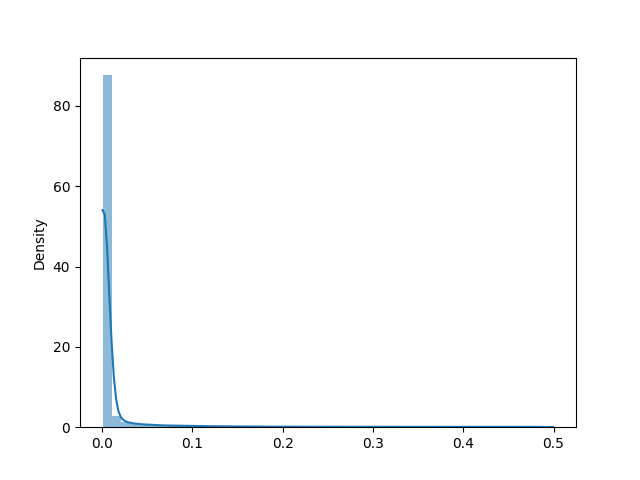

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your list of numbers
plt.figure()
# Plotting the distribution density
sns.histplot((1-torch.concat([dataset.combine_window_to_episode(probs, seq_len)[i].max(1)[0] for i in range(len(seq_len))])).tolist(), kde=True, stat="density", linewidth=0, bins = 50)

# plt.title('Distribution Density Plot')
# plt.xlabel('Value')
# plt.ylabel('Density')

# Show the plot
plt.show()

In [64]:
len(torch.concat([dataset.combine_window_to_episode(probs, seq_len_test)[i].max(1)[0] for i in range(len(seq_len_test))]).tolist())

24045

In [85]:
1-np.percentile(torch.concat([1-dataset.combine_window_to_episode(probs, seq_len_test)[i].max(1)[0] for i in range(len(seq_len_test))]).tolist(), 92.90912871698898)

0.9287880819982638

In [83]:
1-1705/24045

0.9290912871698898

In [40]:
len_list

[150.0,
 238.0,
 326.0,
 372.0,
 429.0,
 506.0,
 575.0,
 660.0,
 708.0,
 782.0,
 801.0,
 889.0,
 961.0,
 1004.0,
 1077.0,
 1102.0,
 1124.0,
 1145.0,
 1212.0,
 1350.0,
 1380.0,
 1431.0,
 1491.0,
 1513.0,
 1601.0,
 1621.0,
 1677.0,
 1721.0,
 1757.0,
 1828.0,
 1871.0,
 1920.0,
 1971.0,
 2040.0,
 2124.0,
 2155.0,
 2165.0,
 2211.0,
 2251.0,
 2293.0,
 2320.0,
 2345.0,
 2425.0,
 2483.0,
 2536.0,
 2582.0,
 2651.0,
 2705.0,
 2793.0,
 2809.0,
 2863.0,
 2939.0,
 2986.0,
 3014.0,
 3078.0,
 3096.0,
 3116.0,
 3143.0,
 3162.0,
 3218.0,
 3263.0,
 3293.0,
 3367.0,
 3426.0,
 3482.0,
 3509.0,
 3555.0,
 3614.0,
 3635.0,
 3706.0,
 3715.0,
 3734.0,
 3767.0,
 3777.0,
 3796.0,
 3839.0,
 3871.0,
 3946.0,
 3966.0,
 4037.0,
 4053.0,
 4132.0,
 4141.0,
 4210.0,
 4229.0,
 4290.0,
 4346.0,
 4356.0,
 4380.0,
 4449.0,
 4470.0,
 4479.0,
 4518.0,
 4536.0,
 4555.0,
 4628.0,
 4655.0,
 4730.0,
 4764.0,
 4797.0,
 4872.0,
 4895.0,
 4922.0,
 4974.0,
 4981.0,
 5003.0,
 5036.0,
 5042.0,
 5048.0,
 5056.0,
 5060.0,
 5087.0,
 5158

In [214]:
dataset.combine_window_to_episode(probs, seq_len_test)[74].max(1)[0][4:43]

tensor([0.9075, 0.9099, 0.9280, 0.9384, 0.9502, 0.9505, 0.9639, 0.9741, 0.9686,
        0.9808, 0.9693, 0.9396, 0.9304, 0.8920, 0.8671, 0.8509, 0.8059, 0.8811,
        0.8652, 0.8091, 0.7311, 0.6646, 0.6384, 0.5624, 0.5818, 0.5763, 0.6694,
        0.7079, 0.5537, 0.5723, 0.8182, 0.8731, 0.9418, 0.9648, 0.9453, 0.8056,
        0.9029, 0.8885, 0.8751])

In [99]:
from sys import maxsize
def maxSubArraySum(a, size):

    max_so_far = -maxsize - 1
    max_ending_here = 0
    start = 0
    end = 0
    s = 0

    for i in range(0, size):

        max_ending_here += a[i]

        if max_so_far < max_ending_here:
            max_so_far = max_ending_here
            start = s
            end = i

        if max_ending_here < 0:
            max_ending_here = 0
            s = i+1

    print("Maximum contiguous sum is %d" % (max_so_far))
    print("Starting Index %d" % (start))
    print("Ending Index %d" % (end))


# Driver program to test maxSubArraySum
a = [-2, -3, 4, -1, -2, 1, 5, -3]
maxSubArraySum(values, len(values))

Maximum contiguous sum is 1
Starting Index 76
Ending Index 84


In [87]:
torch.mean(dataset.combine_window_to_episode(probs, seq_len_test)[-3].max(1)[0])

tensor(0.9657)

In [79]:
def find_lowest_possibilities_region(values):
    # Step 1: Invert the values
    inverted_values = [1 - value for value in values]

    # Step 2: Apply Kadane's Algorithm on the inverted values
    max_so_far = max_ending_here = inverted_values[0]
    start = end = s = 0

    for i in range(1, len(inverted_values)):
        if inverted_values[i] > max_ending_here + inverted_values[i]:
            max_ending_here = inverted_values[i]
            s = i
        else:
            max_ending_here += inverted_values[i]

        if max_ending_here > max_so_far:
            max_so_far = max_ending_here
            start = s
            end = i

    # The region from start to end in the original array is where the possibilities are the lowest
    return (start, end)

# Example usage
values = [0.5, 0.3, 0.6, 0.2, 0.8, 0.1, 0.4]
print(find_lowest_possibilities_region(values))

(0, 6)


In [78]:
sum(1-dataset.combine_window_to_episode(probs, seq_len_test)[-3].max(1)[0])

tensor(3.0514)

In [ ]:
np.save(data_dir + 'rns_emb/test_emb.npy', test_emb.cpu().detach().numpy())

In [ ]:
test_emb.size()

In [ ]:
unique_episodes, unique_episodes_counts = np.unique(index_train[unlabeled_idxs]['episode_index'], return_counts=True)

In [ ]:
import time

uncertainties = probs.max(1)[0]
orders = torch.sort(uncertainties,stable = True)[1]
ranks = torch.argsort(orders)
start_time = time.perf_counter()

rank_list = [ranks[index_train[unlabeled_idxs]['episode_index'] == epi_ind]for epi_ind in unique_episodes]
end_time = time.perf_counter()

elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

In [ ]:
first_n = 5000
from copy import deepcopy
emission_table = []
rank_list_copy = deepcopy(rank_list)
emission_table = [torch.where(rl < first_n, 0.85, 0.15) for rl in rank_list_copy]
rank_list_copy = deepcopy(rank_list)
active_rank_list = [torch.where(rl < first_n, 1, 0) for rl in rank_list_copy]
ordered_rank_list = []
rank_list_copy = deepcopy(rank_list)
active_rank_list = [torch.where(rl < first_n, rl, 0) for rl in rank_list_copy]

In [ ]:
avg_rank = torch.sort(torch.tensor([torch.sum(rl)/(torch.count_nonzero(rl)+1e-6) for rl in active_rank_list]))
episode_rank = avg_rank[1][avg_rank[0]>0]

In [ ]:
active_rank_list[395]

In [ ]:
s = []
for ls in active_rank_list:
    s.append(torch.sum(ls))

In [ ]:
torch.sort(torch.tensor(s),descending =True)

In [ ]:
l[torch.argsort(torch.tensor(s),descending =True)[2]]

In [ ]:
from models.HMM import HMM

hmm = HMM(active_rank_list)


In [ ]:
start_time = time.perf_counter()
filtered_list = []
for i in range(len(active_rank_list)):
    emission_mat_1 = emission_table[i]
    emission_mat_0 = 1-emission_mat_1
    emission_mat = torch.vstack([emission_mat_1,emission_mat_0]).T
    predicted_label = 1 - hmm.predict_labels(active_rank_list[i].numpy(), emission_mat.numpy())
    filtered_list.append(predicted_label)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

In [ ]:
def filter_continuous_positive(array, length_m):

    # Find the indices where 1s start and end
    start_indices = np.where(np.diff(array) == 1)[0] + 1
    end_indices = np.where(np.diff(array) == -1)[0]

    if array[0] == 1:
        start_indices = np.insert(start_indices, 0, 0)
    if array[-1] == 1:
        end_indices = np.append(end_indices, len(array) - 1)

    lengths = end_indices - start_indices + 1

    filtered_indices = start_indices[lengths > length_m]
    filtered_lengths = lengths[lengths>length_m]

    result_array = np.zeros_like(array)
    for start_idx,length in zip(filtered_indices,filtered_lengths):
        result_array[start_idx:start_idx + length] = 1

    return result_array

In [ ]:

start_time = time.perf_counter()
filtered_filtered_list = [filter_continuous_positive(arr,9) for arr in filtered_list]
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

In [ ]:
sum([np.sum(arr) for arr in filtered_filtered_list])

In [ ]:
np.hstack(filtered_filtered_list).shape

In [ ]:
for rd in range(1, NUM_ROUND +1):
    print('round ' + str(rd))
    q_idxs = strategy.query(NUM_QUERY)
    strategy.update(q_idxs)
    strategy.net.round = rd
    strategy.net.net.load_state_dict(modelstate)
    strategy.train()

In [31]:
unlabeled_idxs, unlabeled_data = strategy.dataset.get_unlabeled_data()
probs, seq_len = strategy.predict_prob(unlabeled_data)
uncertainties = probs.max(1)[0]
sliced_uncertainties = dataset.combine_window_to_episode(0.928-uncertainties, seq_len)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 9it [00:00, ?it/s]

array([    0,     1,     2, ..., 85108, 85109, 85110])

In [62]:
metrics = sliced_uncertainties
unlabeled_idxs


array([  25,   37,   56,   74,   90,  103,  150,  197,  226,  237,  248,
        288,  315,  326,  348,  360,  386,  441,  458,  470,  494,  515,
        545,  560,  578,  601,  651,  675,  704,  734,  759,  774,  815,
        847,  881,  892,  940,  951, 1008, 1028, 1054, 1065, 1085, 1111,
       1136, 1167, 1178, 1191, 1216, 1228, 1263, 1274, 1292, 1315, 1346,
       1360, 1372], dtype=int64)

In [50]:
torch.sum(seq_len)

tensor(83560)

In [52]:
len(uncertainties)

83560

In [43]:
torch.flatten(seq_len)

tensor([90, 90, 38, 90, 90, 90, 74, 90, 90, 90, 75, 60, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 57, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 30, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 73, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 89, 90, 90, 90, 90, 90, 58, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 90, 72, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90, 90, 90, 90, 90, 90, 90, 

In [63]:
q_idxs = strategy.query(1710)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 9it [00:00, ?it/s]

In [64]:
q_idxs

array([ 1717,  1718,  1719, ..., 84639, 84640, 84641])

In [65]:
strategy.dataset.labeled_idxs

array([False, False, False, ..., False, False, False])

In [66]:
np.sum(seq_len_train)

85111